## Project 4: Exploring the UK's milk imports and exports

A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse the UK's imports and exports of milk and cream in 2015:

- How much does the UK export and import and is the balance positive (more exports than imports)? 
- Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?
- Which are the regular customers, i.e. which countries buy milk from the UK every month?
- Which countries does the UK both import from and export to?

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

## Getting and preparing the data

The data is obtained from the [United Nations Comtrade](http://comtrade.un.org/data/) website, by selecting the following configuration:

- Type of Product: goods
- Frequency: monthly 
- Periods: January to May of 2014
- Reporter: United Kingdom
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)

Clicking on 'Preview' results in a message that the data exceeds 500 rows. Data was downloaded using the *Download CSV* button and the download file renamed appropriately.

In [2]:
LOCATION = 'comtrade_milk_uk_monthly_14.csv'

The data can also be downloaded directly from Comtrade using the "View API Call" URL, modified in two ways:

- `max=500` is increased to `max=5000` to make sure all data is loaded,
- `&fmt=csv` is added at the end to obtain the data in CSV format.

In [3]:
# LOCATION = 'http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=201505%2C201504%2C201503%2C201502%2C201501&r=826&p=all&rg=1%2C2&cc=0401%2C0402&fmt=csv'

On reading in the data, the commodity code has to be read as a string, to not lose the leading zero.

In [4]:
milk = read_csv(LOCATION, dtype={'Commodity Code':str})
milk.tail(2)

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
1475,HS,2014,201412,December 2014,4,0,2,Exports,826,United Kingdom,...,NaN,NaN,NaN,NaN,100000,NaN,395844,NaN,NaN,0
1476,HS,2014,201412,December 2014,4,0,2,Exports,826,United Kingdom,...,NaN,NaN,NaN,NaN,100000,NaN,261734,NaN,NaN,0


The data only covers the first five months of 2014. Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [5]:
def milkType(code):
    if code == '0401': # neither concentrated nor sweetened
        return 'unprocessed'
    if code == '0402': # concentrated or sweetened
        return 'processed' 
    return 'unknown'

COMMODITY = 'Milk and cream'
milk[COMMODITY] = milk['Commodity Code'].apply(milkType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
milk = milk[headings]
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,201401,World,Imports,unprocessed,21950747
1,201401,World,Exports,unprocessed,46923551
2,201401,Afghanistan,Exports,unprocessed,3410
3,201401,Austria,Exports,unprocessed,316
4,201401,Belgium,Imports,unprocessed,4472349


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [6]:
milk = milk[milk[PARTNER] != 'World']
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
2,201401,Afghanistan,Exports,unprocessed,3410
3,201401,Austria,Exports,unprocessed,316
4,201401,Belgium,Imports,unprocessed,4472349
5,201401,Belgium,Exports,unprocessed,5663128
6,201401,Br. Virgin Isds,Exports,unprocessed,34566


## Total trade flow

To answer the first question, 'how much does the UK export and import and is the balance positive (more exports than imports)?',
the dataframe is split into two groups: exports from the UK and imports into the UK. The  trade values within each group are summed up to get the total trading.

In [7]:
grouped = milk.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports    898651935
Imports    563884942
Name: Trade Value (US$), dtype: int64

This shows a trade surplus of over 100 million dollars arriving over 300 million dollars.

## Main trade partners

To address the second question, 'Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [8]:
imports = milk[milk[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('The UK imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to the UK are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head()

The UK imports from 25 countries.
The 5 biggest exporters to the UK are:


Partner
Ireland        174315886
France         105008176
Germany         76612700
Netherlands     72209235
Belgium         58338745
Name: Trade Value (US$), dtype: int64

The export values can be plotted as a bar chart, making differences between countries easier to see.

<AxesSubplot:ylabel='Partner'>

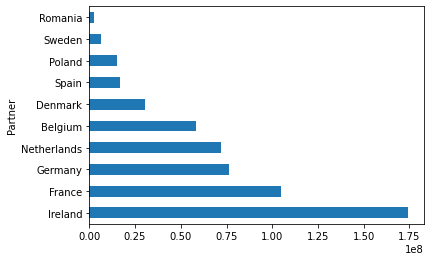

In [9]:
totalImports.head(10).plot(kind='barh')

In [10]:
exports = milk[milk[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('The UK exports to', len(grouped), 'countries.')
print('The 5 biggest importers from the UK are:')
grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).head()

The UK exports to 120 countries.
The 5 biggest importers from the UK are:


Partner
Ireland        421228441
Algeria         93753841
Netherlands     68649082
Germany         36096633
France          34622982
Name: Trade Value (US$), dtype: int64

## Regular importers

Given that there are two commodities, the third question, 'Which are the regular customers, i.e. which countries buy milk from the UK every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly ten rows (two commodities bought each of the five months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [11]:
def buysEveryMonth(group):
    return len(group) == 10

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular[(regular[MONTH] == 201401) & (regular[COMMODITY] == 'processed')]

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
609,201401,Antigua and Barbuda,Exports,processed,15898
663,201401,Saudi Arabia,Exports,processed,318840
675,201401,Burkina Faso,Exports,processed,940671


Just over 75% of the total UK exports are due to these regular customers.

In [12]:
regular[VALUE].sum() / exports[VALUE].sum()

0.007970726730811523

## Bi-directional trade

To address the fourth question, 
'Which countries does the UK both import from and export to?', a pivot table is used to list the total export and import value for each country. 

In [13]:
countries = pivot_table(milk, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head()

Trade Flow,Exports,Imports
Partner,,
Afghanistan,54524.0,NaN
Algeria,93753841.0,NaN
Angola,13305815.0,NaN
Antigua and Barbuda,78006.0,NaN
Australia,102971.0,NaN


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the UK.

In [14]:
countries.dropna()

Trade Flow,Exports,Imports
Partner,,
Austria,136191.0,798816.0
Belgium,29343007.0,58338745.0
Czech Rep.,147573.0,1254989.0
Denmark,2908457.0,30534642.0
Finland,1761424.0,12.0
France,34622982.0,105008176.0
Germany,36096633.0,76612700.0
Greece,36983.0,7.0
Hungary,188933.0,4956.0


## Conclusions

The milk and cream trade of the UK from January to May 2014 was analysed in terms of which countries the UK mostly depends on for income (exports) and goods (imports). Over the period, the UK had a trade surplus of over 100 million US dollars, almost reaching 300 million dollars.

Ireland is the main partner, but it imported from the UK almost the triple in value than it exported to the UK. 

The UK exported to over 200 countries during the period, but only imported from 21 countries, the main ones (top five by trade value) being geographically close. Antigua and Barbuda and Saudi Arabia are the main importers that are not also main exporters. 

The UK is heavily dependent on its regular customers,75% of its exports are due to its customers. They contribute three quarters of the total export value.

The UK has bi-directional trade (i.e. both exports and imports) with 25 countries, although for some the trade value (in US dollars) is suspiciously low, which raises questions about the data's accuracy.


## Now repeat the analysis with your own data gotten from Comtrade website